In [1]:
import skimage
import numpy as np
from scipy import ndimage as ndi
from collections import OrderedDict
from copy import deepcopy
import networkx as nx
from scipy.interpolate import splprep, splev
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.metrics import pairwise_distances
from itertools import combinations
import pdb
from tqdm import tqdm

### preprocess

In [2]:
def binarize_skeletonize_convolve(img):
	#2.  binarize image using histogram based thresholding 
	# -----------------------------
	results = dict()
	threshold = skimage.filters.threshold_minimum(img)
	results['binarized'] = np.where(
		img > threshold,
		1,
		0
	)

	#3. skeletonize image
	#------------------------------------
	skel_binary = skimage.morphology.skeletonize(
		results['binarized']
	)
	skel_numeric = np.where(
		skel_binary,
		1,
		0
	)
	results['skeletonized'] = skel_numeric

	#4. convolutions to detect junctions and wire tips
	#----------------------------------
	weights = np.array(
		[
			[1, 1, 1],
			[1, 0, 1],
			[1, 1, 1]
		]
	)
	convolved = ndi.correlate(
		results['skeletonized'],
		weights,
		mode = 'constant',
		cval = 0
	)
	# filtering out potential junctions/tips that aren't on wires
	convolved *= skel_numeric
	results['convolved'] = convolved

	# identifying wire tips and wire junctions
	tips = np.where(
		convolved == 1,
		1,
		0
	)
	segments = np.where(
		convolved == 2,
		1,
		0
	)
	junctions = np.where(
		convolved >= 3,
		1,
		0
	)
	results['tips'] = tips
	results['segments'] = segments
	results['junctions'] = junctions
	return results

### expand_junctions

In [3]:
def expand_junctions(junctions, segments, footprint, overwrite_segments):
	'''
	junctions -- binary array. 1 where there are junctions, 0 elsewhere
	skeletonized -- binary array. 1 where there are segments, 0 elsewhere	
	footprint -- int. the size of the footprint used in erosion
	overwrite_segments -- bool. whether to delete the portions of segments that are undernerath junctions

	returns combined image of both junctions and segments, image of just junctoins, image of just segments
	'''

	assert junctions.max() <= 0, 'junctions array must be non positive'
	assert segments.min() >= 0, 'segments array must be non negative'

	junctions_expanded = skimage.morphology.erosion(
		image = junctions,
		footprint = np.ones((footprint, footprint))
	)

	if overwrite_segments:
		chunked = np.where(
			junctions_expanded < 0,
			0,
			segments
		)
	else:
		chunked = segments

	combined = np.where(
		chunked > 0,
		chunked,
		junctions_expanded
	)
	return combined, junctions_expanded, chunked

### img_to_rag

In [4]:
def img_to_rag(labeled_image, data = None):
	indices = dict()
	for label in np.unique(labeled_image):
		if label == 0:
			pass
		else:
			indices[label] = [tuple(row) for row in np.argwhere(labeled_image == label)]

	rag = skimage.future.graph.RAG(
		label_image = labeled_image,
		connectivity = 2,
		data = data
	)
	rag.remove_node(0)

	nx.set_node_attributes(rag, indices, 'indices')
	return rag	

			

### merge_nodes

In [5]:
def merge_nodes(rag, n1, n2):
	assert list(rag.nodes[n1].keys()) == list(rag.nodes[n2].keys()), 'Nodes {} and {} have different attribute keys'.format(n1, n2)

	# confirm nodes are of same type
	if 'type' in rag.nodes[n1].keys():
		assert rag.nodes[n1]['type'] == rag.nodes[n2]['type'], 'Nodes {},{} have different types'.format(n1,n2)
	attrs = dict()
	n1_dict, n2_dict = rag.nodes[n1], rag.nodes[n2]
	for key in n1_dict.keys():
		v1 = n1_dict[key]
		v2 = n2_dict[key]
		assert type(v1) == type(v2), 'Junctions {} and {} have attribute {} that are of different types'.format(n1, n2, key)
		if key == 'type':
			assert v1 == v2, 'Junctions {} and {} have different types'.format(n1, n2)
		elif type(v1) == list:
			attrs[key] = v1 + v2
		elif type(v1) == pd.DataFrame:
			attrs[key] = pd.concat(
				[v1, v2]
			)
	nx.contracted_edge(
		rag,
		edge = (n1,n2),
		self_loops = False,
		copy = False
	)
	del rag.nodes[n1]['contraction']
	nx.set_node_attributes(
		rag,
		{n1 : attrs}
	)

### merge_necessary_junctions

In [6]:
def merge_necessary_junctions(rag):
	# merge junctions that are touching at this point
	junction_nodes = [node for node in rag if rag.nodes[node]['type'] == 'junction']
	junction_rag = deepcopy(rag.subgraph(junction_nodes))
	connected_components = list(nx.connected_components(junction_rag))
	for c in connected_components:
		edges = rag.subgraph(c).edges
		while edges:
			j1, j2 = list(edges)[0]
			merge_nodes(rag, j1, j2)
			edges = rag.subgraph(c).edges
			# c may contain junctions that have been merged into other junctions, but this
			# isn't really a problem because subgraph just ignores nodes that ore not in the parent graph
			


	# if multiple junctions touch the same segment_tip, merge those junctions
	# this is necessary so that, when iterate over junctions to reconnect segment tips,
	# there is not order dependence
	segment_tip_nodes = [node for node in rag.nodes if rag.nodes[node]['type'] == 'segment_tip']
	for node in segment_tip_nodes:
		adjacent_junctions = [n for n in rag.neighbors(node) if rag.nodes[n]['type'] == 'junction']
		while len(adjacent_junctions) > 1:
			j1 = adjacent_junctions[0]
			j2 = adjacent_junctions.pop(1)
			rag.add_edge(j1,j2)
			merge_nodes(rag, j1, j2)
	for node in segment_tip_nodes:
		adjacent_junctions = [n for n in rag.neighbors(node) if rag.nodes[n]['type'] == 'junction']
		assert len(adjacent_junctions) >= 1, 'segment_tip {} has no adjacent junctions'.format(node)

### prune_rag_edges

In [7]:
def prune_rag_edges(rag):
	# all edges with junctions must be with segment_tips. now we remove any edges containing 
	# junction and anything else
	allowed_edge_types = [
		{'segment','wire_tip'},
		{'segment','segment_tip'},
		{'segment_tip','junction'},
		{'segment'}
	]
	for edge in rag.edges:
		edge_type = {rag.nodes[node]['type'] for node in edge}
		if edge_type not in allowed_edge_types:
			if edge_type in [{'junction', 'segment'}, {'junction','wire_tip'}]:
				rag.remove_edge(*edge)
			else:
				raise Exception('Edge {} has unexpected type {}'.format(edge, edge_type))

### matching functions

In [8]:
# defining some useful functions for matching
def approaching_matrix(df, delta_t):
	pos = df[['x','y']].values
	_index = lambda x : 0 if x == 'first' else -1
	extended = df.apply(
		lambda row : row[['x','y']].values + (delta_t if row['first_or_last'] == 'last' else -delta_t) * row[['dx','dy']].values,
		axis = 1,
		result_type = 'expand'
	).values
	original_distances = pairwise_distances(
		pos,
		metric = 'euclidean'
	)
	extended_distances = pairwise_distances(
		pos,
		extended,
		metric = 'euclidean'
	)
	approaching = extended_distances < original_distances
	# need tomake sure that BOTH are approaching so we take this matrix and its transpose
	return approaching & approaching.T


def rel_angle(der1, der2):
	costheta = der1.dot(der2) / (np.linalg.norm(der1) * np.linalg.norm(der2))
	assert np.abs(costheta) < 1.001, 'Cos(theta) is {} which is suspiciously large'.format(costheta)
	if np.abs(costheta) > 1:
		return np.arccos(
			np.sign(
				costheta
			)
		)
	else:
		return np.arccos(costheta)

def match_segments(rag, angle_tolerance):
	junctions = [node for node in rag.nodes if rag.nodes[node]['type'] == 'junction']
	for junction in junctions:
		temp_df = rag.nodes[junction]['reconnections']
		# filter out any segments that are already matched
		temp_df = temp_df[temp_df.matched == False]
		# temp_df is the data we will be using for testing out matches. but when we want to write data back to the graph,
		# we should set in rag.nodes[junction]['reconnections']

		# in order to try matching, we need to have at least two segments available to match
		if len(temp_df) < 2:
			continue
		approaching = approaching_matrix(temp_df, delta_t = 3)

		relative_angle = pairwise_distances(
			temp_df[['dx','dy']].values,
			metric = rel_angle
		)
		angle_tolerance_radians = angle_tolerance/360 * 2 * np.pi
		# segments may actually be parallel but because of some randomness in the parametrization, 
		# the will be marked as antiparallel. Either should be sufficient.
		# so we will take the angle between two vectors to be the minimum of (angle, np.pi - angle)
		min_relative_angle = np.minimum(
			relative_angle,
			np.pi - relative_angle	# this is strictly nonn egative because the np.arccos used to return relative_angle returns a value between 0 and pi
		)
		angle_match = min_relative_angle <= angle_tolerance_radians

		# making sure that we are not matching segments to themselves
		one_on_diag = np.diag(
			[1] * angle_match.shape[0]
		)
		not_self = (one_on_diag != 1)

		# making sure that we only consider unique pairs
		not_self_and_unique = np.triu(not_self).astype(bool)

		# it possible for a single junction to touch two segment_tips that are attached to the same segment
		# if this is the case, then these two are not candidates for reconnection
		diff_segments = pairwise_distances(
			temp_df['segment'].values.reshape(-1,1),
			metric = lambda a,b : a!=b
		).astype(bool)

		possible_matches = approaching & angle_match & not_self_and_unique & diff_segments
		while possible_matches.sum() > 0:
			# nothing to do if sum = 0. 
			if possible_matches.sum() == 1:
				# unique pair! yay! the easiest possible outcome
				i1,i2 = np.argwhere(possible_matches).flatten()	# integer indices
				t1, t2 = temp_df.index[[i1,i2]]	# the corresponding segment tips
				s1, s2 = temp_df.loc[[t1,t2], 'segment'] # the corresponding segments
				rag.add_edge(s1, s2)
				# # the segment tips are our indices so we use these to write data back to the original node attribute
				# for t in [t1,t2]:
				# 	rag.nodes[junction]['reonncections'].loc[t, 'matched'] = True
				# # now exclude these from future matching
				# for i in [i1,i2]:
				# 	possible_matches[i,:] = False
				# 	possible_matches[:,i] = False
			elif possible_matches.sum() > 1:
				# there are multiple matches, so we want to figure out which one is best
				possible_match_indices = np.argwhere(possible_matches)
				possible_match_relative_angles = [min_relative_angle[idx[0], idx[1]] for idx in possible_match_indices]
				best_match_index = possible_match_indices[
					np.argmin(
						possible_match_relative_angles
					)
				]
				i1, i2 = best_match_index # integer indices

			# the row indices of our best match are i1 and i2	
			t1, t2 = temp_df.index[[i1,i2]]	# the corresponding segment tips
			s1, s2 = temp_df.loc[[t1,t2], 'segment'] # the corresponding segments
			rag.add_edge(s1, s2)
			# the segment tips are our indices so we use these to write data back to the original node attribute
			rag.nodes[junction]['reconnections'].loc[[t1,t2], 'matched'] = True
			# now we exclude these from future matching in this while loop
			for i in [i1, i2]:
				possible_matches[i,:] = False
				possible_matches[:,i] = False

				# t1,t2 = temp_df.index[[i1,i2]] # corresponding segment tips
				# s1, s2 = temp_df.loc[]
				# rag.add_edge(s1,s2)
				# for s in [s1,s2]:
				# 	df.loc[s, 'matched'] = True
				# # now exclude these indices from future matching 
				# for i in [i1,i2]:
				# 	possible_matches[i,:] = False
				# 	possible_matches[:,i] = False
	segments_rag = rag.subgraph(
		[node for node in rag if rag.nodes[node]['type'] == 'segment']
	)


In [9]:
def breakpoint():
	2 + 2 == 4
	return None

### main()

In [10]:

def img_to_graph(imgpath, 
	footprint = 3,
	angle_tolerance = 20,
	straightening_parameter = None,
	xy_crop = None,
	rowcol_crop = None,
	max_matching_iterations = 15
	):
	results = OrderedDict()

	#1. open image 
	# ------------------------------
	results['original'] = skimage.io.imread(imgpath)
	def _get_last(results):
		last_index = list(results.keys())[-1]
		return results[last_index]

	assert xy_crop is None or rowcol_crop is None, 'Cannot specify both xy_crop and rowcol_crop'
	def _crop(img, crop_iter):
		row_range = slice(crop_iter[0],crop_iter[1])
		col_range = slice(crop_iter[2],crop_iter[3])
		return img[row_range, col_range]
	if rowcol_crop is not None:
		assert len(rowcol_crop) == 4, 'rowcol_crop must have length 4 if it is not None'
		results['original'] = _crop(results['original'], rowcol_crop)
	elif xy_crop is not None:
		assert len(xy_crop) == 4, 'xy_crop must have length 4 if it is not None'
		crop_iter = []
		for n in [2,3,0,1]: # iterating through the coords to output them in row/col order
			c = xy_crop[n]
			if n in [2,3] and c is not None:
				c = -xy_crop[n]
				crop_iter.append(c)
			else:
				crop_iter.append(c)
		results['original'] = _crop(results['original'], crop_iter)


	results.update(
		binarize_skeletonize_convolve(results['original'])
	)

	#2. Expand Junctions and chunk segments
	#-------------------------------

	combined, junctions_expanded, chunked = expand_junctions(
		junctions = -1 * results['junctions'], # junctions is positive in results so we must flip
		segments = results['skeletonized'],
		footprint = footprint,
		overwrite_segments = True
	)

	results['junctions_expanded'] = junctions_expanded
	results['chunked'] = chunked
	# remove small objects
	results['chunked'] = skimage.morphology.remove_small_objects(
		results['chunked'] == 1,
		connectivity = 2,
		min_size = 4
	)
	# recast as integers
	results['chunked'] = results['chunked'].astype(int)

	# because we have removed these small objects, junctions may be isolated

	#3. label each nonzero pixel in the chunked image with a unique positive integer
	# -------------------------------
	chunked_relabeled = deepcopy(results['chunked'])
	pixel_label_to_index = dict()
	new_pixel_label = 1
	for ind in np.argwhere(results['chunked']):
		chunked_relabeled[ind[0], ind[1]] = new_pixel_label
		pixel_label_to_index[new_pixel_label] = (ind[0], ind[1])
		new_pixel_label += 1
	results['chunked_relabeled'] = chunked_relabeled

	#4. label all the junctions with unique labels
	junctions_expanded_labeled = skimage.measure.label(
		label_image = junctions_expanded,
		background = 0,
		connectivity = 2
	)
	junctions_expanded_labeled *= -1 # flipping the sign so all negative

	# making a rag
	combined = np.where(
		chunked_relabeled > 0,
		chunked_relabeled,
		junctions_expanded_labeled
	)
	rag = img_to_rag(combined)
	# labeling node types and adding data containers where appropriate
	for node in rag:
		if node < 0:
			rag.nodes[node]['type'] = 'junction'
			rag.nodes[node]['reconnections'] = []
		elif node > 0:
			idx = rag.nodes[node]['indices'][0]
			if results['tips'][idx] == 1:
				rag.nodes[node]['type'] = 'wire_tip'
			else:
				rag.nodes[node]['type'] = 'segment'
	# making a rag with just the segments
	segments_rag = deepcopy(
		rag.subgraph(
			[node for node in rag if rag.nodes[node]['type'] in ['segment','wire_tip']]
		)
	)

	#9  identifying each segment and listing the segment's nodes in order
	#--------------------------------------
#	segments = dict()
	components = [segments_rag.subgraph(c).copy() for c in nx.connected_components(segments_rag)]
	segments_with_ordered_nodes = []
	for segment_number, component in enumerate(components):
		# finding one of the start nodes of the segment
		for node in component:
			if component.degree(node) < 2: 
				source = node
				break
		
		# adding the nodes in order 
		nodes_in_order = list( 
			nx.dfs_preorder_nodes(
				component,
				source = source
			)
		)	
		segments_with_ordered_nodes.append(nodes_in_order)

	# merging nodes in segments
	segment_tip_nodes = []
	for segment in segments_with_ordered_nodes:
		s = deepcopy(segment)

		# marking the segment tips but only if they are not already marked as wire tips
		segment_tip_1 = s.pop(0)
		if rag.nodes[segment_tip_1]['type'] != 'wire_tip':
			rag.nodes[segment_tip_1]['type'] = 'segment_tip'
			segment_tip_nodes.append(segment_tip_1)
		
		# marking this tip as first (because the nodes are ordered)
		rag.nodes[segment_tip_1]['first_or_last'] = 'first'

		if len(s) >= 1: # if there are nodes remaining
			segment_tip_2 = s.pop(-1) # pop the last one and mark it as a segment tip
			# but only if not already marked as a wire tip 
			if rag.nodes[segment_tip_2]['type'] != 'wire_tip':
				rag.nodes[segment_tip_2]['type'] = 'segment_tip'		
				segment_tip_nodes.append(segment_tip_2)
			# marking this segment tip as last (again because the nodes are ordered)
			rag.nodes[segment_tip_2]['first_or_last'] = 'last'

		# at this point, any remaining nodes are part of the segment interior
		while s:  # now iterate through the remaining nodes and merge them.
			# all should be already labeled as segments
			if len(s) == 1: # if only one node remaining, no merging to do
				node1 = s.pop() # popping only so that we break the loop
			else:
				node1 = s[0]
				node2 = s.pop(1)
				merge_nodes(rag, node1, node2)


	# merge necessary junctions
	merge_necessary_junctions(rag)

	# prune existing edges in the graph
	prune_rag_edges(rag)



	#determine what kinds of reconnections should happen around each junction
	junctions = [node for node in rag if rag.nodes[node]['type'] == 'junction']
	for junction in junctions:
		junction_neighbors = list(rag.neighbors(junction))
		reconnections = []
		if junction_neighbors: # if there are neighbors
			#first confirm that all neighbors are segment tips
			for node in junction_neighbors:
				assert rag.nodes[node]['type'] == 'segment_tip', 'Junction {} is touching node {} which is not a segment tip'.format(junction,node)
			# now iterate through these confirmed segment_tips
			for segment_tip in junction_neighbors:
				segment_tip_neighbors = set(rag.neighbors(segment_tip))
				assert len(segment_tip_neighbors) == 2, 'Segment tip {} should have exactly two neighbors'.format(segment_tip)
				# if we have reached this point, the segment_tip has exactly two neighbors and one of them is the junction
				# the other neighbor then is either a segment or we have fucked up
				should_be_segment = segment_tip_neighbors - {junction}
				should_be_segment = list(should_be_segment)[0]
				assert rag.nodes[should_be_segment]['type'] == 'segment', 'Node {}, which is neighbor of segment tip {}, should be segment but is {}'.format(should_be_segment, segment_tip,rag.nodes[should_be_segment]['type'])

				# if we ahve reached this point, we know that should_be_segment is a segment
				segment = should_be_segment
				# adding reconnection data
				reconnections.append(
					dict(segment_tip = segment_tip,
						segment = segment, 
						first_or_last = rag.nodes[segment_tip]['first_or_last'],
						matched = False,
						x = None,
						y = None,
						dx = None,
						dy = None)
				)
			# now convert reconnections to data frame
			rag.nodes[junction]['reconnections'] = pd.DataFrame(reconnections).set_index('segment_tip')
		else: # if there are no neighbors
			# add empty data frame for this junction
			rag.nodes[junction]['reconnections'] = pd.DataFrame(
				columns = ['segment_tip', 'segment', 'first_or_last','matched', 'x','y','dx','dy']
			).set_index('segment_tip')
								


	


	# assigning coordinates to each node in the graph
	for node in rag:
		coordinates = []
		for idx in rag.nodes[node]['indices']:
			x,y = idx[1], -idx[0]
			coordinates.append((x,y))
		rag.nodes[node]['coordinates'] = coordinates

	# adding the tip coordinates to the segment coordinates and confirming that each segment is bounded by 
	# exactly two tips
	# this will make the parametrizations more accurate
	# note that the segments COORDINATES will contain the coordinates of the tips but not the indices of the tips
	segments = [node for node in rag if rag.nodes[node]['type'] == 'segment']
	for s in segments:
		tip_neighbors = [n for n in rag.neighbors(s) if 'tip' in rag.nodes[n]['type']]
		# confirming exactly two tip neighbors1
		assert len(tip_neighbors) == 2, 'Segment {} does not have exactly two tip neighbors'.format(s)
		# confirming that there is one first neighbor and one last neighbor 
		neighbor_order_type = {rag.nodes[n]['first_or_last'] for n in tip_neighbors}
		assert neighbor_order_type == {'first', 'last'}, 'Tip neighbors of segment {} should have types first and last but instead have types {}'.format(s,neighbor_order_type)

		for tip_neighbor in tip_neighbors:
			if rag.nodes[tip_neighbor]['first_or_last'] == 'first':
				rag.nodes[s]['coordinates'] = rag.nodes[tip_neighbor]['coordinates'] + rag.nodes[s]['coordinates']
			elif rag.nodes[tip_neighbor]['first_or_last'] == 'last':
				rag.nodes[s]['coordinates'] = rag.nodes[s]['coordinates'] + rag.nodes[tip_neighbor]['coordinates']

	# converting coordinates to np.array
	for node in rag:
		rag.nodes[node]['coordinates'] = np.array(rag.nodes[node]['coordinates'])

 	# making splines for each segment in the graph
	segments = [node for node in rag if rag.nodes[node]['type'] == 'segment']
	for segment in segments: 
		# at this point the segments should have lists of coordinates that are at least 4 rows long
		assert len(rag.nodes[segment]['coordinates']) >= 4, 'Segment {} is too short.'.format(segment)
		k = 3	# if segment is 4 pixels or longer, use cubic splines
		coordinates = rag.nodes[segment]['coordinates']
		num_anchors = 4 * np.floor(len(coordinates) / 20 + 1)	# we want 4 anchor points for every 20 pixels
		num_anchors = int(num_anchors)
		anchor_indices = np.linspace(
			start = 0,
			stop = len(coordinates) - 1,
			num = num_anchors
		)
		anchor_indices = [int(i) for i in anchor_indices]
		anchor_points = [coordinates[i] for i in anchor_indices]
		x = [c[0] for c in anchor_points]
		y = [c[1] for c in anchor_points]
		tck, u = splprep(
				[x,y],
				s = len(x) + np.sqrt(2 * len(x)), # this smoothing chosen as the average one recommended in manual
				k = k,
				u = list(range(len(x)))
		)
		rag.nodes[segment]['spline'] = (u, tck)
		curve = splev(u,tck)
		# converting curve to nparray
		x = curve[0]
		y = curve[1]
		curve = np.array([el for el in zip(x,y)])
		rag.nodes[segment]['curve'] = curve
		xp, yp = splev(u, tck, der = 1) # calculating derivatives
		der = [np.array(el) for el in zip(xp, yp)]
		der = [el / np.linalg.norm(el) for el in der] # normalizing
		der = np.round(der, 5) # rounding
		rag.nodes[segment]['der'] = der

		if straightening_parameter:
			w = straightening_parameter / len(coordinates)
			straight = np.linspace(
				coordinates[0,:],
				coordinates[-1,:],
				len(curve)
			)
			straight_der = (straight[-1] - straight[0]) / len(u) # u is array of parameter values
			rag.nodes[segment]['curve'] = (curve + w * straight) / (1 + w)
			rag.nodes[segment]['der'] = (der + w * straight_der) / (1 + w)
			


	# populating useful data of reconnections dataframe in each junction
	junction_nodes = [node for node in rag.nodes if rag.nodes[node]['type'] == 'junction']
	for junction in junction_nodes:
		df = rag.nodes[junction]['reconnections']
		for segment_tip in df.index:
			segment = df.loc[segment_tip, 'segment']
			idx = 0 if df.loc[segment_tip, 'first_or_last'] == 'first' else -1
			df.loc[segment_tip, ['x','y']] = rag.nodes[segment]['curve'][idx]
			df.loc[segment_tip,['dx','dy']] = rag.nodes[segment]['der'][idx]
		rag.nodes[junction]['reconnections'] = df # this might be unnecessary because the values should already be changed but I'm superstitious

	results['rags'] = [deepcopy(rag)]

	# performing the first batch of reconections
	match_segments(rag, angle_tolerance = angle_tolerance)


	# checking to see if we have matched all the segments
	all_segments_matched = True
	for junction in [node for node in rag if rag.nodes[node]['type'] == 'junction']:
		df = rag.nodes[junction]['reconnections']
		df = df[df.matched == False]
		if len(df) > 0:
			all_segments_matched = False
			break
	counter = 0
	results['rags'].append(rag)

	def gsr(rag):
		return deepcopy(
			rag.subgraph(
				[node for node in rag if rag.nodes[node]['type'] == 'segment']
			)
		)

	results['pre_rag_images'] = [combined]
	pbar = tqdm(range(1,15), desc = 'Matching')
#	while all_segments_matched == False and counter < 15:
	for counter in pbar:
		if all_segments_matched:
			break
		# status message
		jdf = pd.concat([rag.nodes[n]['reconnections'] for n in rag if rag.nodes[n]['type'] == 'junction'])
		pbar.set_postfix(
			{'matched' : '{:d}/{:d}'.format(
				int(jdf.matched.sum()), int(len(jdf)))})

		# create labeled junctions image and labeled segments image
		# don't forget that nodes of type segment_tip or wire_tip should also be in the segments image
		junctions = np.zeros(results['original'].shape)
		segments = np.zeros(results['original'].shape)
		for node in rag:
			if rag.nodes[node]['type'] == 'junction':
				for idx in rag.nodes[node]['indices']:
					junctions[idx] = node
			elif rag.nodes[node]['type'] in ['segment', 'segment_tip','wire_tip']:
				for idx in rag.nodes[node]['indices']:
					segments[idx] = node


		# expand junctions (without overwriting segments)
		combined, junctions, segments = expand_junctions(
			junctions = junctions,
			segments = segments,
			footprint = footprint,
			overwrite_segments = False
		)
		results['pre_rag_images'].append(combined)
		
#		print('iter', counter)
#		print('old rag segs recon count = {}'.format(len(gsr(rag).edges)))

		# create new rag and make sure that no nodes have been lost in this process
		if counter == 5:
			breakpoint()
		new_rag = img_to_rag(
			combined,
			data = rag
			)
		assert set(rag.nodes) == set(new_rag.nodes)
#		print('new rag segs recon count after creation = {}'.format(len(gsr(new_rag).edges)))

		# merge junctions where  appropriate
		merge_necessary_junctions(new_rag)
#		print('new rag segs recon count after merge junctions = {}'.format(len(gsr(new_rag).edges)))


		# prune existing edges in the rag
		prune_rag_edges(new_rag)
#		print('new rag segs recon count after prune edges = {}'.format(len(gsr(new_rag).edges)))


		# match segments
		match_segments(new_rag, angle_tolerance = angle_tolerance)
#		print('new rag segs recon count after matching = {}'.format(len(gsr(new_rag).edges)))


		rag = deepcopy(new_rag)
		results['rags'].append(rag)


	return results

### Execute

In [11]:
results = img_to_graph(
	imgpath = '/Users/adamtrebach/Documents/Research/TPV/Nanowires/sample nw images/301.tif',
	footprint = 3,
	angle_tolerance = 20,
	straightening_parameter = 10,
	xy_crop = [100, 300, -600, None],
	max_matching_iterations = 15
	)



Matching:   7%|▋         | 1/14 [00:00<00:05,  2.24it/s, matched=28/40]Traceback (most recent call last):
  File "_pydevd_bundle/pydevd_cython.pyx", line 1078, in _pydevd_bundle.pydevd_cython.PyDBFrame.trace_dispatch
  File "_pydevd_bundle/pydevd_cython.pyx", line 297, in _pydevd_bundle.pydevd_cython.PyDBFrame.do_wait_suspend
  File "/Users/adamtrebach/opt/anaconda3/envs/envnw/lib/python3.10/site-packages/debugpy/_vendored/pydevd/pydevd.py", line 1976, in do_wait_suspend
    keep_suspended = self._do_wait_suspend(thread, frame, event, arg, suspend_type, from_this_thread, frames_tracker)
  File "/Users/adamtrebach/opt/anaconda3/envs/envnw/lib/python3.10/site-packages/debugpy/_vendored/pydevd/pydevd.py", line 2011, in _do_wait_suspend
    time.sleep(0.01)
KeyboardInterrupt
Matching:   7%|▋         | 1/14 [00:20<04:21, 20.13s/it, matched=28/40]


KeyboardInterrupt: 

In [26]:
tips = [node for node in rag if rag.nodes[node]['type'] == 'wire_tip']
print(tips)
list(rag.neighbors(-11))

[3, 4, 1, 2, 7, 341, 504, 520, 789, 801, 809, 817, 916, 939, 981, 1095, 1098, 1101, 1102, 1103]


[761, 777, 778, 810, 795]

In [29]:
for node in tips:
	print('node {} at index {}'.format(node, rag.nodes[node]['indices'][0]))

node 3 at index (1, 42)
node 4 at index (1, 74)
node 1 at index (0, 144)
node 2 at index (0, 150)
node 7 at index (1, 169)
node 341 at index (52, 162)
node 504 at index (72, 0)
node 520 at index (74, 116)
node 789 at index (108, 96)
node 801 at index (109, 199)
node 809 at index (111, 0)
node 817 at index (112, 29)
node 916 at index (124, 0)
node 939 at index (130, 119)
node 981 at index (137, 52)
node 1095 at index (165, 161)
node 1098 at index (166, 113)
node 1101 at index (167, 35)
node 1102 at index (167, 118)
node 1103 at index (167, 180)


node 817 is the problem here. should be connected to junction 11

In [31]:
list(rag.neighbors(817))

[917]

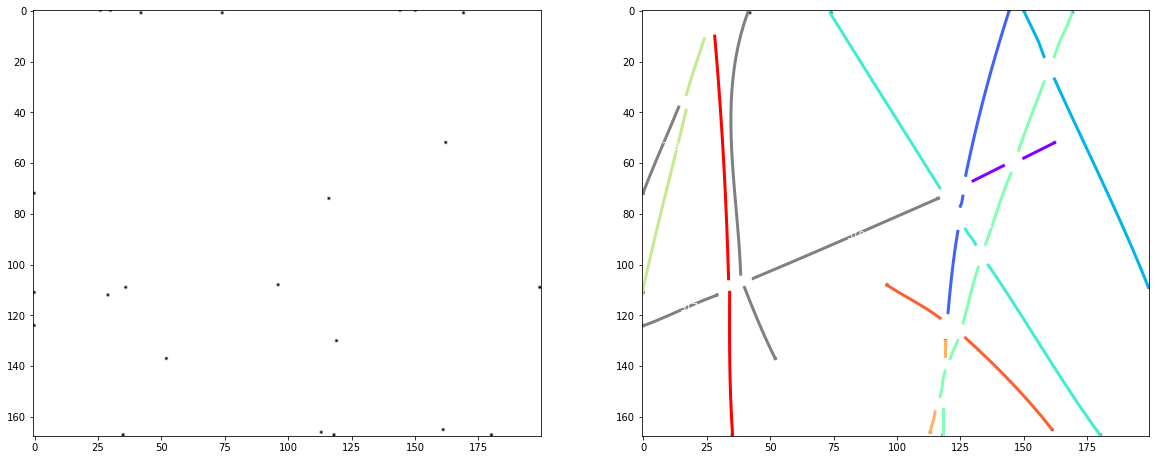

In [33]:
fig, axs = plt.subplots(
	figsize = (20, 10),
	ncols = 2
)
ax = axs[0]
ax.imshow(
	results['tips'],
	cmap = 'binary'
)
ax =axs[1]
segments = [node for node in rag if rag.nodes[node]['type'] == 'segment']
segments_rag = rag.subgraph(segments)
connected_segments = [comp for comp in nx.connected_components(segments_rag) if len(comp) > 1]
isolated_segments = [comp for comp in nx.connected_components(segments_rag) if len(comp) == 1]
color = iter(
	plt.cm.rainbow(
		np.linspace(0, 1, len(connected_segments))
	)
)
junctions_img = np.zeros(results['original'].shape)
for node in rag:
	val = 0
	if rag.nodes[node]['type'] == 'wire_tip':
		val = 1
	if val > 0:
		for idx in rag.nodes[node]['indices']:
			junctions_img[idx] = val
ax.imshow(
	junctions_img,
	cmap = 'binary'
)
for component in connected_segments:
	c = next(color)
	for segment in component:
		ax.plot(
			rag.nodes[segment]['curve'][:,0],
			-rag.nodes[segment]['curve'][:,1],
			c = c,
			lw = 3
		)
for iso in isolated_segments:
	for segment in iso:
		ax.plot(
			rag.nodes[segment]['curve'][:,0],
			-rag.nodes[segment]['curve'][:,1],
			c = 'gray',
			lw = 3
		)
		ax.annotate(
			segment,
			(
				np.average(rag.nodes[segment]['curve'][:,0]),
				np.average(-rag.nodes[segment]['curve'][:,-1])
			)	,
			color = 'white'
		)
for node in rag:
	if rag.nodes[node]['type'] == 'junction':
		ax.annotate(
			node,
			(
				a := np.average((coords := np.array(rag.nodes[node]['indices']))[:,1]),
				np.average(	coords[:,0])
			),
			fontsize = 10,
			color = 'white'
		)
plt.show()

In [16]:
rags = results['rags']
fig, axs = plt.subplots(
	figsize = (10, 10 * len(rags)),
	nrows = len(rags)
)
for rag_index, rag in enumerate(rags):
	segments = [node for node in rag if rag.nodes[node]['type'] == 'segment']
	segments_rag = rag.subgraph(segments)
	ax = axs.flatten()[rag_index]
	ax.set_title(rag_index)
	connected_segments = [comp for comp in nx.connected_components(segments_rag) if len(comp) > 1]
	isolated_segments = [comp for comp in nx.connected_components(segments_rag) if len(comp) == 1]
	color = iter(
		plt.cm.rainbow(
			np.linspace(0, 1, len(connected_segments))
		)
	)
	junctions_img = np.zeros(results['original'].shape)
	for node in rag:
		val = 0
		if rag.nodes[node]['type'] == 'junction':
			val = 1
		elif rag.nodes[node]['type'] == 'wire_tip':
			val = 20
		if val > 0:
			for idx in rag.nodes[node]['indices']:
				junctions_img[idx] = val
	ax.imshow(
		junctions_img
	)
	for component in connected_segments:
		c = next(color)
		for segment in component:
			ax.plot(
				rag.nodes[segment]['curve'][:,0],
				-rag.nodes[segment]['curve'][:,1],
				c = c,
				lw = 3
			)
	for iso in isolated_segments:
		for segment in iso:
			ax.plot(
				rag.nodes[segment]['curve'][:,0],
				-rag.nodes[segment]['curve'][:,1],
				c = 'gray',
				lw = 3
			)
			ax.annotate(
				segment,
				(
					np.average(rag.nodes[segment]['curve'][:,0]),
					np.average(-rag.nodes[segment]['curve'][:,-1])
				)	,
				color = 'white'
			)
	for node in rag:
		if rag.nodes[node]['type'] == 'junction':
			ax.annotate(
				node,
				(
					a := np.average((coords := np.array(rag.nodes[node]['indices']))[:,1]),
					np.average(	coords[:,0])
				),
				fontsize = 10,
				color = 'white'
			)
	ax.set_aspect('equal')
plt.savefig(
	'/Users/adamtrebach/Documents/Research/TPV/Nanowires/reconstructed.png',
	dpi = 200
)
plt.close()